In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit, MultilabelStratifiedKFold

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
df_external = pd.read_csv('external/external.csv')
df_external.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [7]:
highest_ratio = df['Target'].value_counts()[df['Target'].value_counts()>1000].index.tolist()
highest_ratio

['0', '25 0', '23', '25', '7', '4', '21']

In [8]:
df_external = df_external[~df_external['Target'].isin(highest_ratio)]

In [9]:
len(df_external)

36291

In [10]:
df_complete = df.append(df_external).reset_index(drop=True)

In [11]:
#df_complete = df_full.sample(frac=0.5).reset_index(drop=True, inplace=True)

In [12]:
len(df), len(df_external), len(df_complete)

(31072, 36291, 67363)

### get better validation split since the classes are very unevenly represented

In [13]:
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

In [14]:
def plot_ratio(targets):
    labels_num = [value.split() for value in targets]
    labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
    labels = ["" for _ in range(len(labels_num_flat))]
    for i in range(len(labels_num_flat)):
        labels[i] = subcell_locs[labels_num_flat[i]]

    fig, ax = plt.subplots(figsize=(15, 5))
    pd.Series(labels).value_counts().plot('bar', fontsize=14)

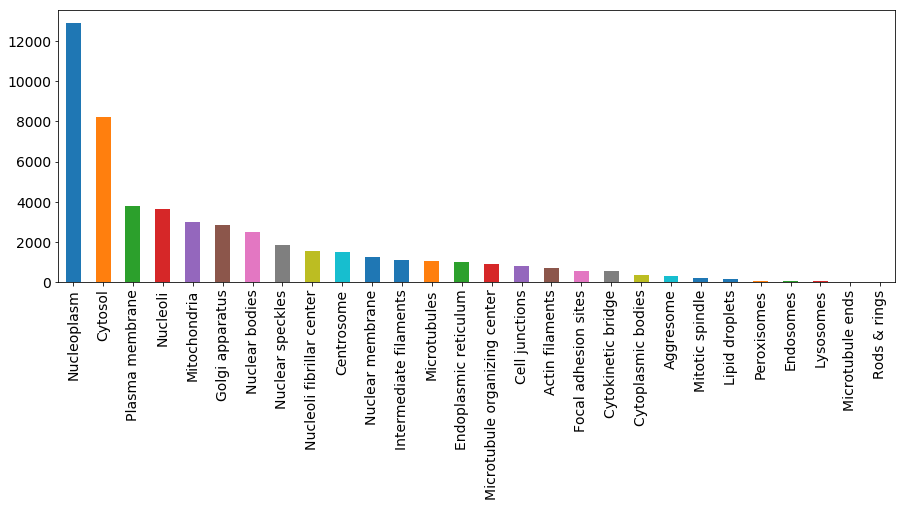

In [15]:
plot_ratio(df['Target'])

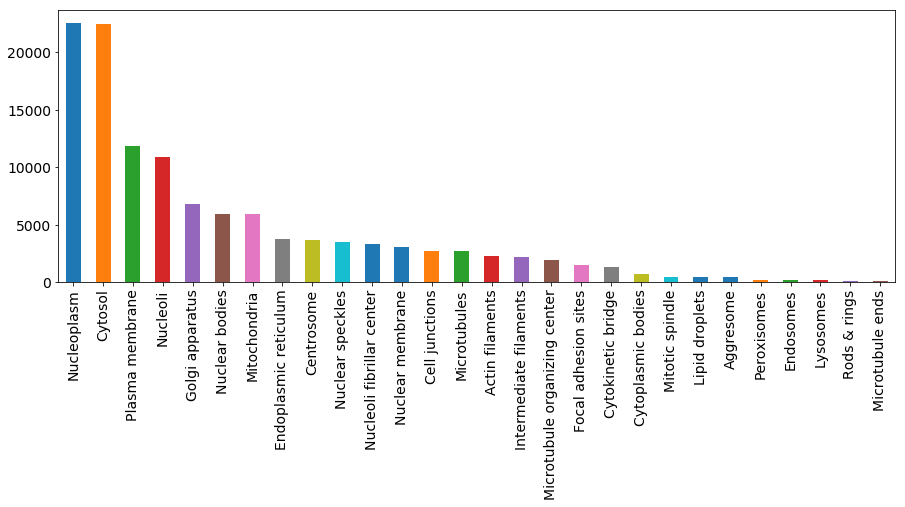

In [16]:
plot_ratio(df_complete['Target'])

In [17]:
class Fold:
    def __init__(self, trn_id, val_id):
        self.train_index = trn_id
        self.val_index = val_id

In [18]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42)
    
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

folds = []

for train_index, val_index in mskf.split(X, y):
    print("Train:", len(train_index), "Valid:", len(val_index))
    fold = Fold(train_index, val_index)
    folds.append(fold)
    #folds[i] = np.append(train_index, val_index)
   
del X, y
gc.collect()

Train: 24878 Valid: 6194
Train: 24889 Valid: 6183
Train: 24889 Valid: 6183
Train: 24820 Valid: 6252
Train: 24812 Valid: 6260


2

In [19]:
#k_fold = IterativeStratification(n_splits=5, order=1, random_state=21)
#    
#train_df_orig = df.copy()
#    
#X = train_df_orig['Id'].tolist()
#y = train_df_orig['Target'].tolist()
#y = MultiLabelBinarizer().fit_transform(y)
#folds = []
#
#for train_index, val_index in k_fold.split(X, y):
#    print("Train:", len(train_index), "Valid:", len(val_index))
#    fold = Fold(train_index, val_index)
#    folds.append(fold)
#    #folds[i] = np.append(train_index, val_index)
#   
#del X, y
#gc.collect()

In [20]:
np.save(path/'folds_iterstrat', folds)

In [21]:
#folds = np.load(path/'folds_iterstrat.npy')

In [22]:
train_index = folds[0].train_index
val_index = folds[0].val_index

In [23]:
train_index = np.append(train_index, [i for i in range(len(df), len(df_complete))])
len(train_index), len(val_index), len(df_complete)

(61169, 6194, 67363)

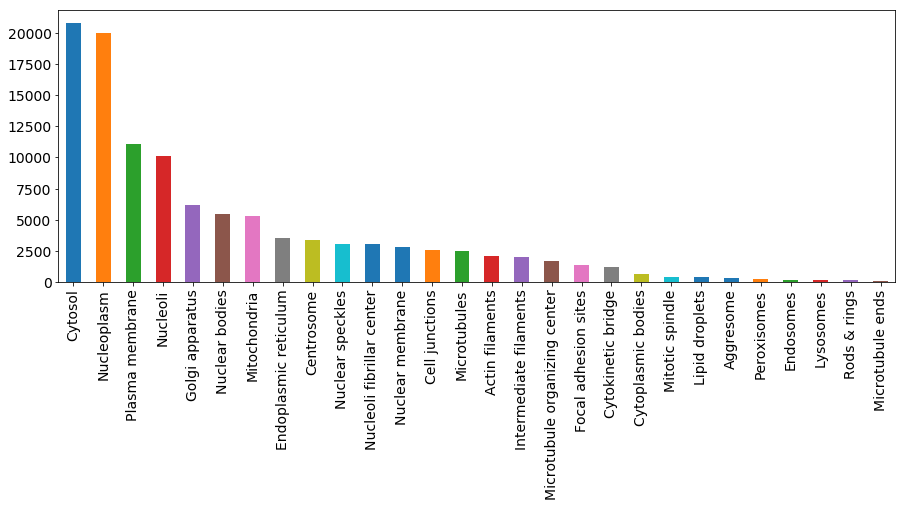

In [24]:
plot_ratio(df_complete.loc[train_index]['Target'])

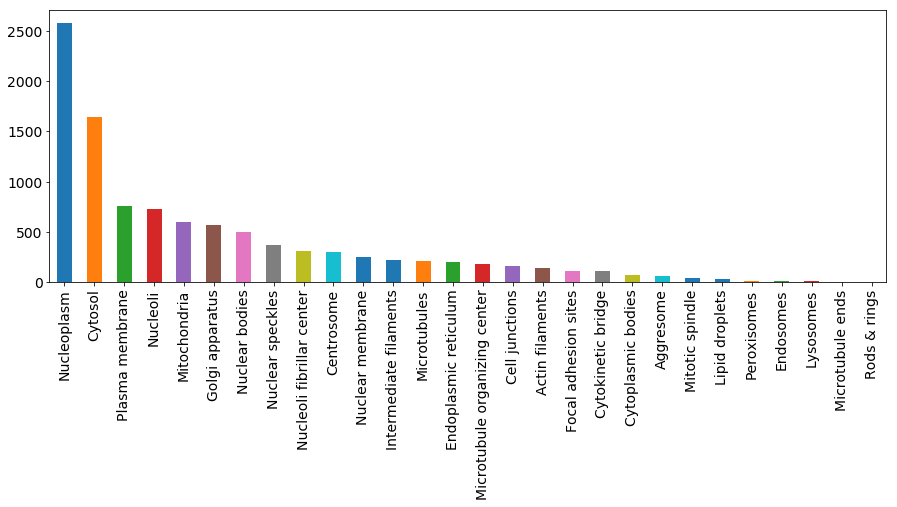

In [25]:
plot_ratio(df_complete.loc[val_index]['Target'])

### set everything we need for creating a ImageMultiDataset

In [26]:
fns = pd.Series([id + '.png' for id in df_complete.Id])
labels = [targ.split(' ') for targ in df_complete.Target]
classes=[str(i) for i in range(28)]

In [27]:
trn_mask=[]

for i in range(len(df_complete)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(67363, 61169, 6194)

### create train, valid and test ImageMultiDataset

In [28]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 61169, ImageMulti4Channel of len 6194)

In [29]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [30]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### Calculate mean/std for this dataset

In [31]:
#means = torch.zeros(4)
#stds = torch.zeros(4)

In [32]:
#count = len(fns) 

In [33]:
#count

In [34]:
#colors = ['red','green','blue','yellow']
#
#for fname in fns:
#    channels = [open_image('data/train/'+fname[:-4]+'_'+color+'.png', convert_mode='L').data for color in colors]
#    
#    stack = np.stack(channels, axis=-1)
#    img = Image(pil2tensor(stack[0,:,:], np.float32).float()).data
#    
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2]), torch.mean(img[3])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2]), torch.std(img[3])])
    
#for fname in test_ids:
#    channels = [open_image('data/test/'+fname+'_'+color+'.png', convert_mode='L').data for color in colors]
#    
#    stack = np.stack(channels, axis=-1)
#    img = Image(pil2tensor(stack[0,:,:], np.float32).float()).data
#    
#    means += torch.Tensor([torch.mean(img[0]), torch.mean(img[1]), torch.mean(img[2]), torch.mean(img[3])])
#    stds += torch.Tensor([torch.std(img[0]), torch.std(img[1]), torch.std(img[2]), torch.std(img[3])])

#mean = means/count
#std = stds/count
#mean, std

### define transforms, normalization and metric

In [35]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [36]:
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
#                      max_lighting=0.2, max_warp=0.2)

In [37]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.,
                      max_lighting=0.2, max_warp=0.)

In [38]:
#without majority classes

#protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

#with test set
#stats_train_external = ([0.0574, 0.0478, 0.0311, 0.0848], [0.0899, 0.0748, 0.0793, 0.1265]) 

stats_train_external = ([0.0571, 0.0483, 0.0294, 0.0892],[0.0875, 0.0739, 0.0745, 0.1314])

### create ImageDataBunch from all this

In [39]:
#torch.backends.cudnn.benchmark = True
src_size = 512

In [40]:
bs = 48

In [41]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(stats_train_external)

In [42]:
data.train_ds, data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 61169),
 DatasetTfm(ImageMulti4Channel of len 6194))

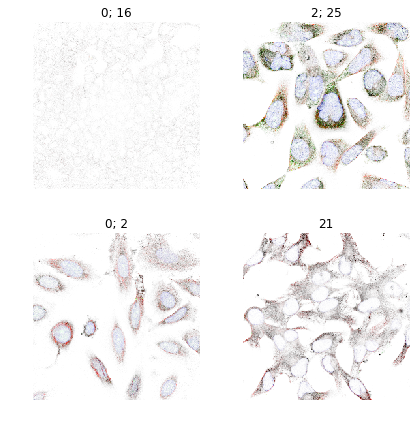

In [43]:
data.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

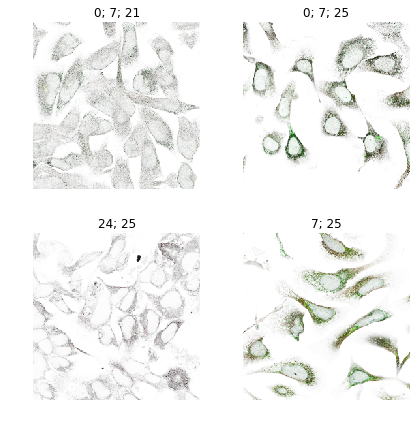

In [44]:
data.show_batch(rows=2, figsize=(6,6))

### create model and learner

In [45]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

def resnet101(pretrained=True):
    return Resnet4Channel(encoder_depth=101, pretrained=pretrained)

def resnet152(pretrained=True):
    return Resnet4Channel(encoder_depth=152, pretrained=pretrained)

In [46]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [47]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [48]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [49]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [50]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [51]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [52]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2): #gamma=4 working pretty bad
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [53]:
learn = create_cnn(
    data,
    resnet50,
    ps=[0.5, 0.5],
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

RuntimeError: CUDA error: out of memory

In [ ]:
learn.loss_func = FocalLoss()

In [54]:
learn.clip = 1.0 #gradient clipping

NameError: name 'learn' is not defined

In [55]:
learn.loss_func, learn.opt_func

NameError: name 'learn' is not defined

In [57]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [58]:
learn.freeze()

In [59]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [60]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 61169),
 DatasetTfm(ImageMulti4Channel of len 6194))

In [61]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


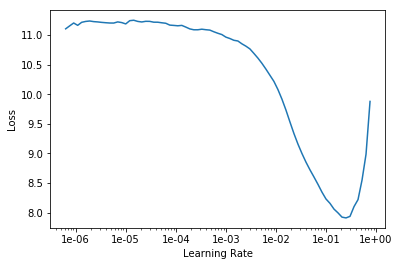

In [62]:
learn.recorder.plot() #skmulti IterativeStratification

In [63]:
lr = 1e-3

### fit the model (half image size)

Total time: 08:52
epoch  train_loss  valid_loss  fbeta  acc        
1      1.270167    1.070731    0.449849  0.951670  (08:51)



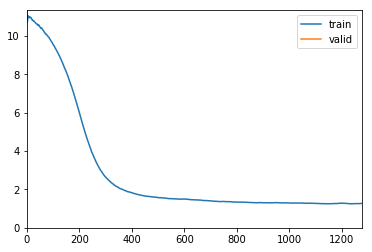

In [64]:
learn.fit_one_cycle(1, max_lr=slice(lr)) 

In [65]:
learn.save('halfsz_res50_frozen')

### unfreeze there resnet layers and train again 

In [48]:
learn.load('halfsz_res50_frozen')

In [66]:
learn.unfreeze()

In [67]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


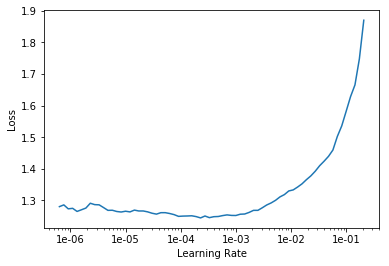

In [68]:
learn.recorder.plot() #skmulti IterativeStratification

In [69]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [70]:
#lrs = slice(1e-5, 1e-4) 
lr = 3e-4
lrs = slice(lr/2, lr) 

In [71]:
learn.lr_range(lrs)

array([0.00015 , 0.000212, 0.0003  ])

epoch,train_loss,valid_loss,fbeta,acc
1,1.100793,0.917803,0.563143,0.957644


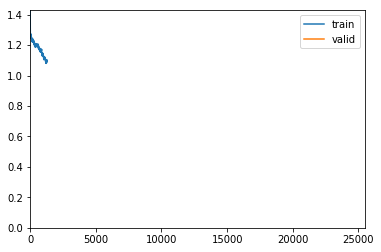

KeyboardInterrupt: 

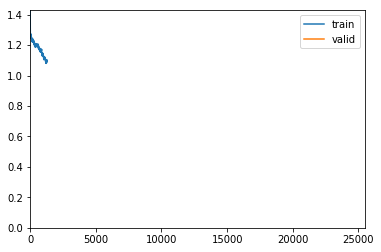

In [72]:
learn.fit_one_cycle(20, max_lr=lrs) #skmulti IterativeStratification

Total time: 3:14:27
epoch  train_loss  valid_loss  fbeta  acc        
1      1.103298    0.903791    0.564208  0.958277  (09:42)
2      0.984829    0.817978    0.621370  0.961961  (09:43)
3      0.939925    0.756218    0.662801  0.963919  (09:42)
4      0.906619    0.773631    0.643131  0.962822  (09:42)
5      0.902350    0.756283    0.657908  0.964039  (09:41)
6      0.888949    0.734405    0.670281  0.964624  (09:41)
7      0.871873    0.711851    0.675114  0.965807  (09:43)
8      0.849277    0.691555    0.695977  0.966249  (09:43)
9      0.820735    0.685000    0.698873  0.967431  (09:43)
10     0.801250    0.634034    0.719956  0.969600  (09:43)
11     0.765193    0.612874    0.733730  0.970863  (09:43)
12     0.770920    0.627722    0.727014  0.970163  (09:43)
13     0.743275    0.580673    0.746055  0.972068  (09:42)
14     0.706730    0.571098    0.751310  0.972384  (09:43)
15     0.693656    0.563634    0.754331  0.972940  (09:43)
16     0.682088    0.555178    0.759543  0.97

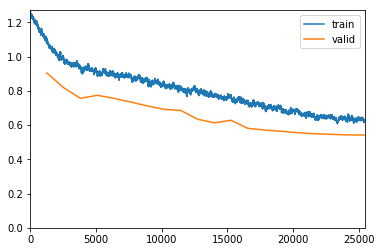

In [69]:
learn.fit_one_cycle(20, max_lr=lrs) #skmulti IterativeStratification

In [70]:
learn.save('halfsz_res50_unfrozen')

### train on whole picture (512px)

In [52]:
bs = 14

In [53]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(stats_train_external)

In [54]:
learn = create_cnn(
    data,
    resnet50,
    ps=[0.5, 0.5],
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [55]:
learn.loss_func = FocalLoss()

In [56]:
learn.split(split_on=_resnet_split)

In [57]:
learn.clip = 1.0 #gradient clipping

In [58]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [59]:
learn.load('bestmodel')

In [60]:
learn.unfreeze()

In [61]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


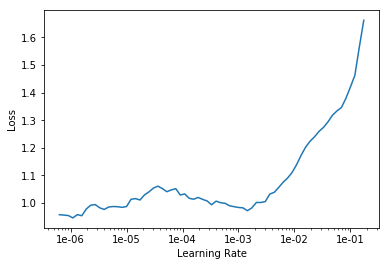

In [62]:
learn.recorder.plot() #skmulti IterativeStratification

In [63]:
learn.callback_fns.append(partial(SaveModel, every='epoch', monitor='val_loss'))

In [64]:
lr = 5e-5

lrs = slice(lr/2, lr)

In [65]:
learn.lr_range(lrs)

array([2.500000e-05, 3.535534e-05, 5.000000e-05])

In [ ]:
learn.save('fullsz_res50_unfrozen')

epoch,train_loss,valid_loss,fbeta,acc
1,0.768529,0.615248,0.746111,0.972189
2,0.718155,0.567132,0.759717,0.973290
3,0.712536,0.561117,0.762573,0.973732
4,0.701357,0.556019,0.763506,0.973612
5,0.710567,0.533177,0.775895,0.974633
6,0.736803,0.545590,0.768264,0.974145
7,0.695546,0.540779,0.768544,0.973847
8,0.650002,0.542334,0.768305,0.974381
9,0.647775,0.558833,0.769856,0.974037
10,0.717886,0.540750,0.777426,0.974903


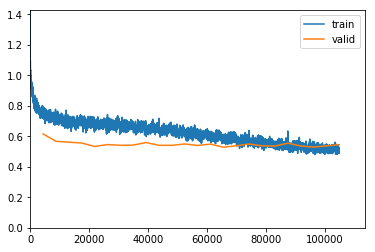

KeyboardInterrupt: 

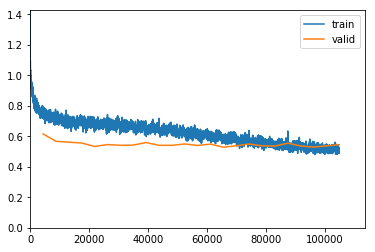

In [73]:
learn.fit_one_cycle(26, lrs, div_factor=10) #4e-5 slice(lr/2, lr/1) resnet50 

Total time: 13:13:11
epoch  train_loss  valid_loss  fbeta  acc        
1      0.773638    0.578668    0.741883  0.972555  (38:42)
2      0.726395    0.544482    0.765156  0.973920  (38:32)
3      0.698088    0.547765    0.765345  0.974596  (38:34)
4      0.729725    0.520295    0.770272  0.974940  (38:35)
5      0.687055    0.533407    0.770568  0.974642  (38:36)
6      0.715829    0.537105    0.765400  0.975032  (38:37)
7      0.682547    0.555751    0.755238  0.973817  (38:37)
8      0.669416    0.541632    0.774907  0.974172  (38:38)
9      0.669623    0.514944    0.775853  0.975307  (38:36)
10     0.651485    0.518639    0.777651  0.975514  (38:36)
11     0.634407    0.509765    0.783544  0.975755  (38:38)
12     0.635411    0.510596    0.783220  0.976133  (38:39)
13     0.580348    0.511086    0.782272  0.976133  (41:13)
14     0.563865    0.502752    0.786648  0.976271  (40:39)
15     0.583895    0.508140    0.791320  0.976409  (42:46)
16     0.557824    0.511036    0.789570  0.9

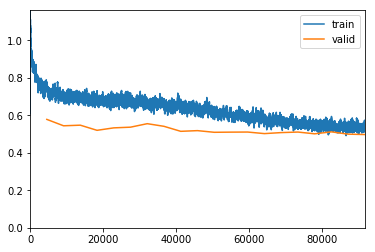

In [74]:
learn.fit_one_cycle(20, lrs, div_factor=10) #5e-5 slice(lr/2, lr/1) resnet50 

## try to improve best model 

In [59]:
learn.load('bestmodel_25')

In [60]:
learn.unfreeze()

In [57]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


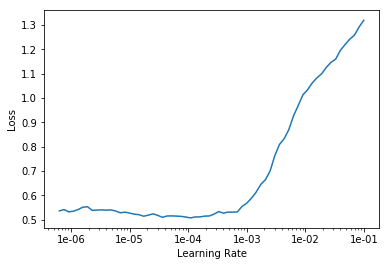

In [58]:
learn.recorder.plot() 

In [59]:
lr = 2e-5

lrs = slice(lr/2, lr)
learn.lr_range(lrs)

array([1.000000e-05, 1.414214e-05, 2.000000e-05])

In [74]:
#learn.fit_one_cycle(10, lrs, div_factor=10) #1e-4 slice(lr/2, lr/1) same split

In [55]:
learn.save('fullsz_res50_unfrozen_improve')

### Try to find a good Threshold

In [75]:
#learn.load('best/bestmodel_externalres50')
learn.load('bestmodel_22')

In [76]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [78]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 09:53



In [118]:
act_preds_tta = torch.sigmoid(preds_tta)

In [119]:
act_preds[0].round(), y[0]

(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### lafoss validation thresh

In [120]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(classes))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [123]:
preds_np = preds_tta.numpy()
y_np = y.numpy()

In [124]:
th = fit_val(preds_np,y_np)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y_np, preds_np>th, average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y_np, preds_np>0.0, average='macro'))
print('F1 micro: ',f1_score(y_np, preds_np>th, average='micro'))

Thresholds:  [-0.289351  0.039502 -0.227488 -0.306709 -0.091113 -0.109232 -0.155142 -0.060407 -0.256223  0.011632 -0.100686
 -0.217414 -0.084274 -0.598592 -0.160403 -0.12672  -0.467496 -0.340029 -0.270858 -0.549921  0.076723 -0.063851
 -0.625108 -0.540874  0.407782 -0.188257 -0.453326  0.      ]
F1 macro:  0.7223797644939884
F1 macro (th = 0.0):  0.6922202249877819
F1 micro:  0.7905853952926976


/home/dollofcuty/anaconda3/envs/fastai/lib/python3.7/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [125]:
print('Fractions: ',(preds_np > th).mean(axis=0))
print('Fractions (true): ',(y_np > 0.5).mean(axis=0))

Fractions:  [4.417484e-01 3.599550e-02 1.068616e-01 3.679897e-02 5.270770e-02 7.874016e-02 2.506830e-02 8.018641e-02 8.034710e-04
 8.034710e-04 8.034710e-04 2.635385e-02 1.735497e-02 1.864053e-02 3.438856e-02 3.213884e-04 1.221276e-02 3.213884e-03
 2.860357e-02 4.419090e-02 4.017355e-03 1.009160e-01 2.876426e-02 1.010767e-01 6.267074e-03 2.691628e-01 9.802346e-03
 0.000000e+00]
Fractions (true):  [0.412984 0.038245 0.116343 0.043387 0.061064 0.085168 0.032942 0.090471 0.000803 0.000964 0.000964 0.035996 0.022336
 0.018962 0.034228 0.000482 0.016873 0.006588 0.031335 0.04869  0.006267 0.117146 0.026836 0.100755 0.008517 0.260325
 0.010124 0.000643]


In [ ]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

In [126]:
fbeta(preds_tta, y, thresh=torch.from_numpy(th).float(), sigmoid=False)

tensor(0.7865)

In [127]:
f1_thresh(th)

0.7223797644939884

### predict test set 

In [113]:
#preds_t,y_t = learn.get_preds(DatasetType.Test)

In [109]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 18:40



In [142]:
#act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [155]:
tuned_weights = (weights*0.8)
#tuned_weights = th * 1
tuned_weights

array([0.4 , 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.16, 0.16, 0.16, 0.32, 0.32, 0.32, 0.32, 0.16, 0.32, 0.32,
       0.32, 0.32, 0.16, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.16])

In [156]:
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.327)[0]])) \
#               for row in np.array(ensamble_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>tuned_weights)[0]])) \
               for row in np.array(act_preds_t_tta)]

### replace empty predicitons with lower thresh/highest probablility

In [157]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [158]:
for ind in indices: 
    pred_labels[ind] = \
    ' '.join(list([str(i) for i in np.nonzero(act_preds_t_tta[ind].numpy()>tuned_weights)[0]]))
    #print(pred_labels[ind])

In [183]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [151]:
for ind in indices:
    act_preds_t_tta[ind]
    _max = torch.max(act_preds_t_tta[ind])
    argmax = ((act_preds_t_tta[ind] == _max).nonzero())
    pred_labels[ind] = str(argmax.numpy()[0][0])

### create submission and replace the leaked prediction for leaderboard comparison

In [159]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [160]:
len(sub['Predicted'][sub['Predicted']==''])

31

In [175]:
#test_matches = pd.read_csv(path/'test_matches.csv')

In [176]:
#test_matches.head()

,Extra,Test,SimR,SimG,SimB,Target,Target_noisey
0,ENSG00000001497_44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,10,6,2,25 18 0,NaN
1,ENSG00000006194_35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,0,0,0,25 17 0,NaN
2,ENSG00000008324_47377_688_E7_10,b029f372-bad9-11e8-b2b9-ac1f6b6435d0,2,0,2,23 2,NaN
3,ENSG00000019186_63771_1414_D12_2,adc182fa-bad2-11e8-b2b8-ac1f6b6435d0,6,2,0,23 0 21,NaN
4,ENSG00000025770_67932_1255_A3_4,39508fe6-bad3-11e8-b2b8-ac1f6b6435d0,0,0,0,16 0,NaN


In [164]:
#for _, row in test_matches.iterrows():
#    print(sub[sub.Id == row.Test].Predicted)
#    sub['Predicted'][sub.Id == row.Test] = row.Target
#    print(sub[sub.Id == row.Test].Predicted)

5419    0 18 25
Name: Predicted, dtype: object
5419    25 18 0
Name: Predicted, dtype: object
3901    0 17 25
Name: Predicted, dtype: object
3901    25 17 0
Name: Predicted, dtype: object
8073    23 25
Name: Predicted, dtype: object
8073    23 2
Name: Predicted, dtype: object
7947    0 21 25
Name: Predicted, dtype: object
7947    23 0 21
Name: Predicted, dtype: object
2571    0 16
Name: Predicted, dtype: object
2571    16 0
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
2214    0 14 16 25
Name: Predicted, dtype: object
2214    14 0
Name: Predicted, dtype: object
1838    14 25
Name: Predicted, dtype: object
1838    14
Name: Predicted, dtype: object
9721    14 16
Name: Predicted, dtype: object
9721    14
Name: Predicted, dtype: object
6119    0 16
Name: Predicted, dtype: object
6119    0
Name: Predicted, dtype: object
783    0 16 21
Name: Predicted, dtype: object
783    21
Name: Predicted, dtype: object
9781    7 23


9881    12
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
10215    4 25
Name: Predicted, dtype: object
10215    18 17
Name: Predicted, dtype: object
4345    0 23
Name: Predicted, dtype: object
4345    23
Name: Predicted, dtype: object
6479    0 16 25
Name: Predicted, dtype: object
6479    0
Name: Predicted, dtype: object
1108    0 1
Name: Predicted, dtype: object
1108    1 0
Name: Predicted, dtype: object
10394    0 13
Name: Predicted, dtype: object
10394    13
Name: Predicted, dtype: object
7993    0 13 21 25
Name: Predicted, dtype: object
7993    13
Name: Predicted, dtype: object
6806    14 25
Name: Predicted, dtype: object
6806    25 14
Name: Predicted, dtype: object
550    23
Name: Predicted, dtype: object
550    23
Name: Predicted, dtype: object
6103    12 25
Name: Predicted, dtype: object
6103    12 25
Name: Predicted, dtype: object
1728    14 17 25
Name: Predicted, dtype: object
1728    25 14 17
Name: Predicted, d

Name: Predicted, dtype: object
5966    0 14 18 19 21 25
Name: Predicted, dtype: object
5966    25 18 14
Name: Predicted, dtype: object
488    4 23
Name: Predicted, dtype: object
488    23 4
Name: Predicted, dtype: object
9068    0 21 25
Name: Predicted, dtype: object
9068    25 0 21
Name: Predicted, dtype: object
6267    19
Name: Predicted, dtype: object
6267    19
Name: Predicted, dtype: object
406    0 20 23
Name: Predicted, dtype: object
406    25 20
Name: Predicted, dtype: object
11535    0 20 23
Name: Predicted, dtype: object
11535    25 20
Name: Predicted, dtype: object
8265    0 16
Name: Predicted, dtype: object
8265    16 0
Name: Predicted, dtype: object
8782    19 24
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
9047    0 2
Name: Predicted, dtype: object
9047    2 21
Name: Predicted, dtype: object
5299    7 25
Name: Predicted, dtype: object
5299    25 7
Name: Predicted, dtype: object
4162    0
Name: Predicted, dtype: object
4162    0
Name: Predicted,

## public lb f1 scores:

### using with_external/best/bestmodel_externalres50_4E 

### with leak

- 0.579 

- 0.568 with one fold

### without leak

- 0.554 filling nulls

- 0.557 not filling nulls thresh * 0.845 (best val thresh)

- 0.555 not filling nulls thresh * 0.9

- 0.558 not filling nulls thresh * 0.8

### using 1 fold

- 0.555 thresh * 1, filling nulls: thresh * 0.9

- 0.556 thresh * 0.9

- 0.562 ensamble (0.1, 0.9), thresh ensamble (0.2, 0.8)

In [161]:
sub.to_csv(path/'resnet50.csv', header=True, index=False)

In [162]:
pred_labels

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '2 20 25',
 '4 5 25',
 '4 21 25',
 '0 25',
 '0',
 '4 21 25',
 '7 25',
 '3 5 25',
 '25',
 '7 20 25',
 '21 23 25',
 '5 18 25',
 '2 14',
 '0 5',
 '14',
 '5',
 '1 6 25',
 '2 25',
 '0 21 25',
 '21',
 '4',
 '12 21 25',
 '0',
 '0',
 '0 25',
 '0 5',
 '0 13 21',
 '0 18 21',
 '14 17 18 25',
 '5 25',
 '0 7 25',
 '13',
 '19 21 25',
 '3',
 '0 5 25',
 '0 1',
 '0 21 25',
 '6 25',
 '0 21 25',
 '1 19 25',
 '18 25',
 '6 20 25',
 '0',
 '0 21',
 '6',
 '0',
 '25',
 '0 5',
 '20 23 24',
 '21 25',
 '3',
 '0 21 25',
 '0 25',
 '11',
 '0 21 25',
 '21 25',
 '2 20',
 '0 5 21 25',
 '14 25',
 '7 21 25',
 '23 25',
 '0 25',
 '3 21 25',
 '25',
 '0 20',
 '14',
 '2',
 '0 2 25',
 '14',
 '4',
 '21',
 '0',
 '0 4',
 '0 1 21 25',
 '0 25',
 '0 25',
 '0 5 25',
 '0 25',
 '0 5 21',
 '0 21 25',
 '18',
 '0 25',
 '23',
 '0 21',
 '14',
 '14 25',
 '0 25',
 '11 21',
 '23',
 '12 13 27',
 '23 25',
 '0 25',
 '19 21 25',
 '0 7 25',
 '24',
 '0 23 25',
 '11 25',
 '7 23 25',
 '2 5 21 23',
 '0 2 4 23',
 '7',

### Lafoss thresholding stuff

In [ ]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [ ]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [ ]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p


In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [ ]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')